# Vehicle Detection

In [1]:
import numpy as np
import cv2

from skimage.feature import hog

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import time
import os


# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# prepare data

def read_files_list(base_dir, dirs):
    files = []
    
    for curr_dir in dirs:
        files.extend(glob.glob(os.path.join(base_dir, curr_dir, '*')))
        
    return files
    
vehicles_base_dir = './data/vehicles'
vehicles_dirs = ['GTI_Far', 'GTI_Left', 'GTI_MiddleClose', 'GTI_Right', 'KITTI_extracted']
vehicles_files = read_files_list(vehicles_base_dir, vehicles_dirs)
print('Found {0} vehicle images'.format(len(vehicles_files)))

not_vehicles_base_dir = './data/non-vehicles'
not_vehicles_dirs = ['Extras', 'GTI']
not_vehicles_files = read_files_list(not_vehicles_base_dir, not_vehicles_dirs)
print('Found {0} not vehicle images'.format(len(not_vehicles_files)))


Found 8792 vehicle images
Found 8968 not vehicle images


In [3]:
def visualize(images, nrows, ncols, figsize, titles=None, img_cmap=None):
    if titles is None:
        titles = ['']*len(images)
    
    fig = plt.figure(figsize=figsize)
    
    for i, img in enumerate(images):
        plt.subplot(nrows, ncols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_cmap is not None:
            plt.imshow(img, cmap=img_cmap)
        elif img_dims < 3:
            plt.imshow(img, cmap='hot')
        else:
            plt.imshow(img)
            
        plt.title(titles[i])

In [4]:
from features import bin_spatial, color_hist, extract_features

from car_detect import find_windows, process_car_candidates
from car_detect_svm import train, find_cars

from car_tracker import VehicleTracker, CarDetectorSvm, CarDetectorNN

Using TensorFlow backend.


## Histogram of Oriented Gradients (HOG)

| **CRITERIA** | **MEETS SPECIFICATIONS** |
|------|------|
| Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters. | Explanation given for methods used to extract HOG features, including which color space was chosen, which HOG parameters (orientations, pixels_per_cell, cells_per_block), and why. |

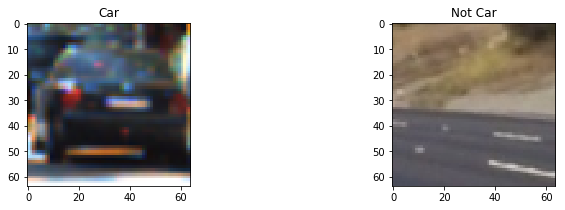

In [5]:
# choose random car and not car images
car_ind = np.random.randint(0, len(vehicles_files))
not_car_ind = np.random.randint(0, len(not_vehicles_files))

car_file = vehicles_files[car_ind]
not_car_file = not_vehicles_files[not_car_ind]

car_img = mpimg.imread(car_file)
not_car_img = mpimg.imread(not_car_file)

visualize([car_img, not_car_img], 1, 2, figsize=(12, 3), titles=['Car', 'Not Car'])

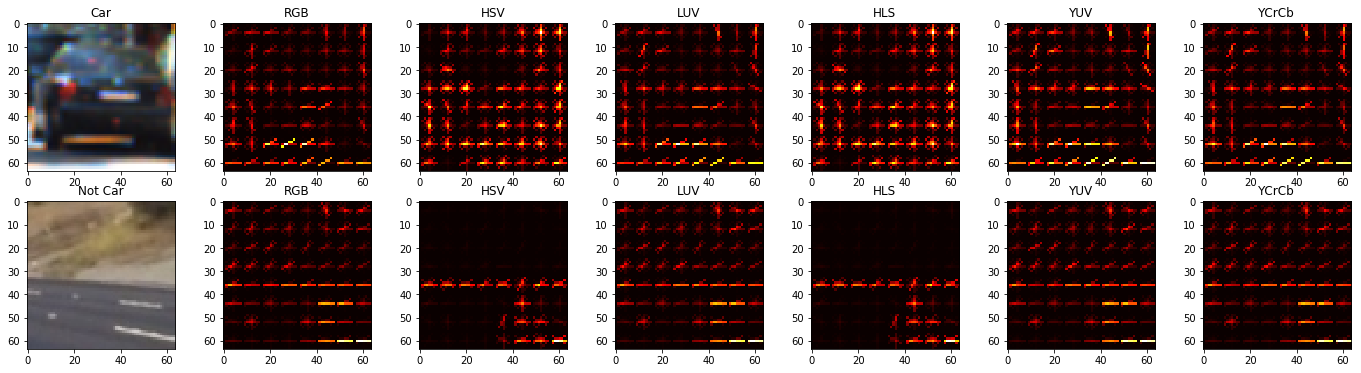

In [6]:
# define features params
color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
cs = color_spaces[0]

# color params
spatial_size = (16, 16) # (32, 32)

# histogram params
hist_bins = 16 #32

# HOG params
orient = 6 #9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 #[0, 1, 2, 'ALL']

result_car_hog_images = []
result_not_car_hog_images = []

for cs in color_spaces:
    car_features, car_hog_images = extract_features([car_file], cs, spatial_size, hist_bins, 
                                            orient, pix_per_cell, cell_per_block, hog_channel, 
                                           vis_hog=True)
    result_car_hog_images.extend(car_hog_images)

    not_car_features, not_car_hog_images = extract_features([not_car_file], cs, spatial_size, hist_bins, 
                                            orient, pix_per_cell, cell_per_block, hog_channel, 
                                           vis_hog=True)
    result_not_car_hog_images.extend(not_car_hog_images)

visuliaze_imgs = [car_img]
visuliaze_imgs.extend(result_car_hog_images)
visuliaze_imgs.append(not_car_img)
visuliaze_imgs.extend(result_not_car_hog_images)

titles = ['Car']
titles.extend(color_spaces)
titles.append('Not Car')
titles.extend(color_spaces)

visualize(visuliaze_imgs, 2, 1 + len(color_spaces), figsize=(24,6), titles=titles)

| **CRITERIA** | **MEETS SPECIFICATIONS** |
|------|------|
| Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them). | The HOG features extracted from the training data have been used to train a classifier, could be SVM, Decision Tree or other. Features should be scaled to zero mean and unit variance before training the classifier. |

In [7]:
# define features params
color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
cs = color_spaces[5]

# color params
spatial_size = (32, 32)

# histogram params
hist_bins = 32

# HOG params
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' #[0, 1, 2, 'ALL']

num_samples = 1000
cars_idxs = np.random.randint(0, len(vehicles_files), num_samples)
not_cars_idxs = np.random.randint(0, len(not_vehicles_files), num_samples)

start_time = time.time()

test_cars = np.array(vehicles_files)[cars_idxs]
test_not_cars = np.array(not_vehicles_files)[not_cars_idxs]

car_features = extract_features(test_cars, cs, spatial_size, hist_bins, 
                                            orient, pix_per_cell, cell_per_block, hog_channel, 
                                           vis_hog=False)

not_car_features = extract_features(test_not_cars, cs, spatial_size, hist_bins, 
                                            orient, pix_per_cell, cell_per_block, hog_channel, 
                                           vis_hog=False)

spent_time = time.time() - start_time
print('Feature extraction spent time {0:.2f} seconds'.format(spent_time))

X = np.vstack((car_features, not_car_features)).astype(np.float64)

# Normalize data
# fit a per column scaler
X_scaler = StandardScaler().fit(X)
# apply the scaler to X
X_scaled = X_scaler.transform(X)

# define the labels vector y
# 1 - is the label for Car
# 0 - is the label for Not Car
y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))


# split the data into train and test sets
# train_test_split splits arrays into random train and test subsets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

# Train using LinearSVC (Linear Support Vector Classification)
start_time = time.time()
svc = LinearSVC()
svc.fit(X_train, y_train)

spent_time = time.time() - start_time
print('Training spent time {0:.2f} seconds'.format(spent_time))

# check the test accuracy of the model
test_accuracy = svc.score(X_test, y_test)
print('Test Accuracy: {0:.3f}'.format(test_accuracy))


Feature extraction spent time 8.18 seconds
Feature vector length: 8460
Training spent time 9.99 seconds
Test Accuracy: 1.000


In [8]:
# # Set the parameters by cross-validation
# #parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
# parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
#                     {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
# svc = SVC()
# clf = GridSearchCV(svc, parameters)
# clf.fit(X_train, y_train)


# print("Best parameters set found on development set:")
# print()
# print(clf.best_params_)
# print()
# print("Grid scores on development set:")
# print()
# means = clf.cv_results_['mean_test_score']
# stds = clf.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
# print()

# print("Detailed classification report:")
# print()
# print("The model is trained on the full development set.")
# print("The scores are computed on the full evaluation set.")
# print()
# y_true, y_pred = y_test, clf.predict(X_test)
# print(classification_report(y_true, y_pred))
# print()


"""
Best parameters set found on development set:

{'gamma': 0.0001, 'kernel': 'rbf', 'C': 10}

Grid scores on development set:

0.783 (+/-0.142) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 1}
0.987 (+/-0.004) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 1}
0.804 (+/-0.137) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 10}
0.988 (+/-0.007) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 10}
0.804 (+/-0.137) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 100}
0.988 (+/-0.007) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 100}
0.804 (+/-0.137) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 1000}
0.988 (+/-0.007) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 1000}
0.988 (+/-0.006) for {'kernel': 'linear', 'C': 1}
0.988 (+/-0.006) for {'kernel': 'linear', 'C': 10}
0.988 (+/-0.006) for {'kernel': 'linear', 'C': 100}
0.988 (+/-0.006) for {'kernel': 'linear', 'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99        95
        1.0       1.00      0.99      1.00       105

avg / total       1.00      0.99      1.00       200
"""


"\nBest parameters set found on development set:\n\n{'gamma': 0.0001, 'kernel': 'rbf', 'C': 10}\n\nGrid scores on development set:\n\n0.783 (+/-0.142) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 1}\n0.987 (+/-0.004) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 1}\n0.804 (+/-0.137) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 10}\n0.988 (+/-0.007) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 10}\n0.804 (+/-0.137) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 100}\n0.988 (+/-0.007) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 100}\n0.804 (+/-0.137) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 1000}\n0.988 (+/-0.007) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 1000}\n0.988 (+/-0.006) for {'kernel': 'linear', 'C': 1}\n0.988 (+/-0.006) for {'kernel': 'linear', 'C': 10}\n0.988 (+/-0.006) for {'kernel': 'linear', 'C': 100}\n0.988 (+/-0.006) for {'kernel': 'linear', 'C': 1000}\n\nDetailed classification report:\n\nThe model is trained on the full development set.\nThe scores are computed on the full eval

### Train the Final Model

In [9]:
# the best model

# define features params
cs = 'YCrCb'
# color params
spatial_size = (32, 32)
# histogram params
hist_bins = 32
# HOG params
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

classifier, X_scaler = train(vehicles_files, not_vehicles_files,
                             cs, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
                             spatial_feat=True, hist_feat=True, hog_feat=True)

Feature extraction spent time 87.38 seconds
Feature vector length: 8460
Training spent time 9.41 seconds
Test Accuracy: 0.993


In [10]:
# # the best model with no spatial_feat and no hist_feat

# # define features params
# cs = 'YCrCb'
# # color params
# spatial_size = (32, 32)
# # histogram params
# hist_bins = 32
# # HOG params
# orient = 9
# pix_per_cell = 8
# cell_per_block = 2
# hog_channel = 'ALL'

# classifier2, X_scaler2 = train(vehicles_files, not_vehicles_files,
#                                cs, spatial_size, hist_bins,
#                                orient, pix_per_cell, cell_per_block, hog_channel,
#                                spatial_feat=False, hist_feat=False, hog_feat=True)

## Sliding Window Search

| **CRITERIA** | **MEETS SPECIFICATIONS** |
|------|------|
| Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows? | A sliding window approach has been implemented, where overlapping tiles in each test image are classified as vehicle or non-vehicle. Some justification has been given for the particular implementation chosen. |

Detected windows number: 31


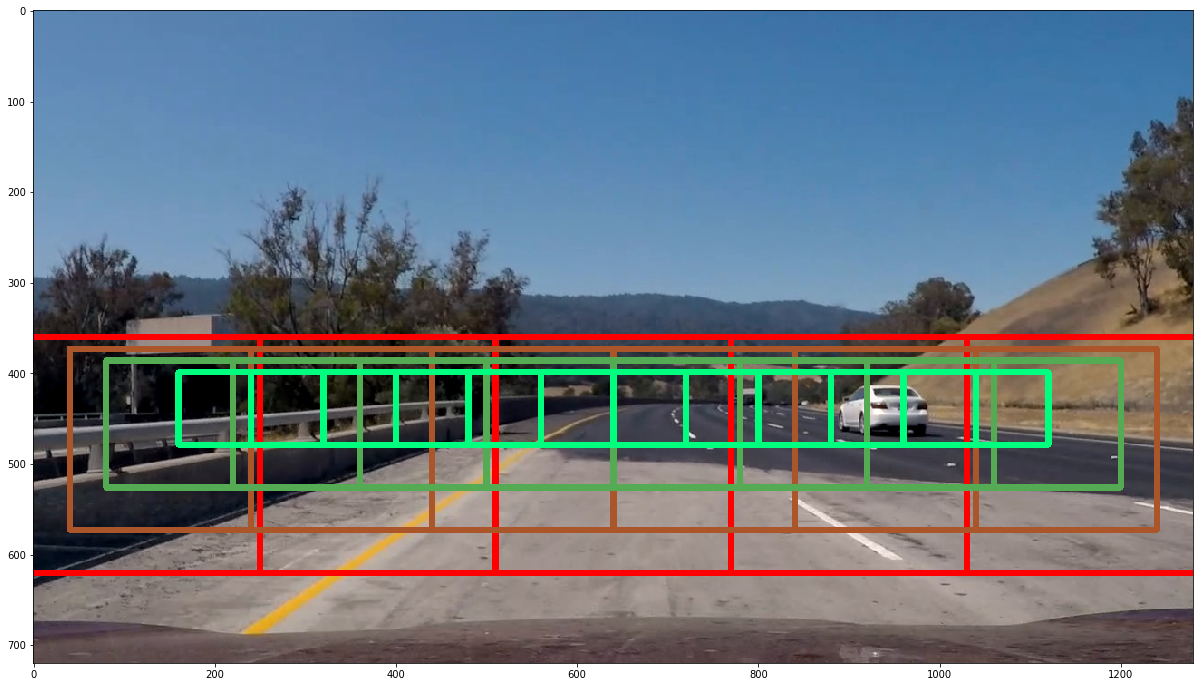

In [11]:
#img = mpimg.imread('./test_images/1/0.jpg')
img = mpimg.imread('./test_images/608.jpg')
wins_img, wins = find_windows(img, dx_start=0, dx_stop=200, 
                              x_overlap_start=0, x_overlap_stop=0, 
                              n_levels=4, visualize=True)
plt.figure(figsize=(24,12))
plt.imshow(wins_img)

| **CRITERIA** | **MEETS SPECIFICATIONS** |
|------|------|
| Show some examples of test images to demonstrate how your pipeline is working. How did you optimize the performance of your classifier? | Some discussion is given around how you improved the reliability of the classifier i.e., fewer false positives and more reliable car detections (this could be things like choice of feature vector, thresholding the decision function, hard negative mining etc.) |

Detected windows number: 164


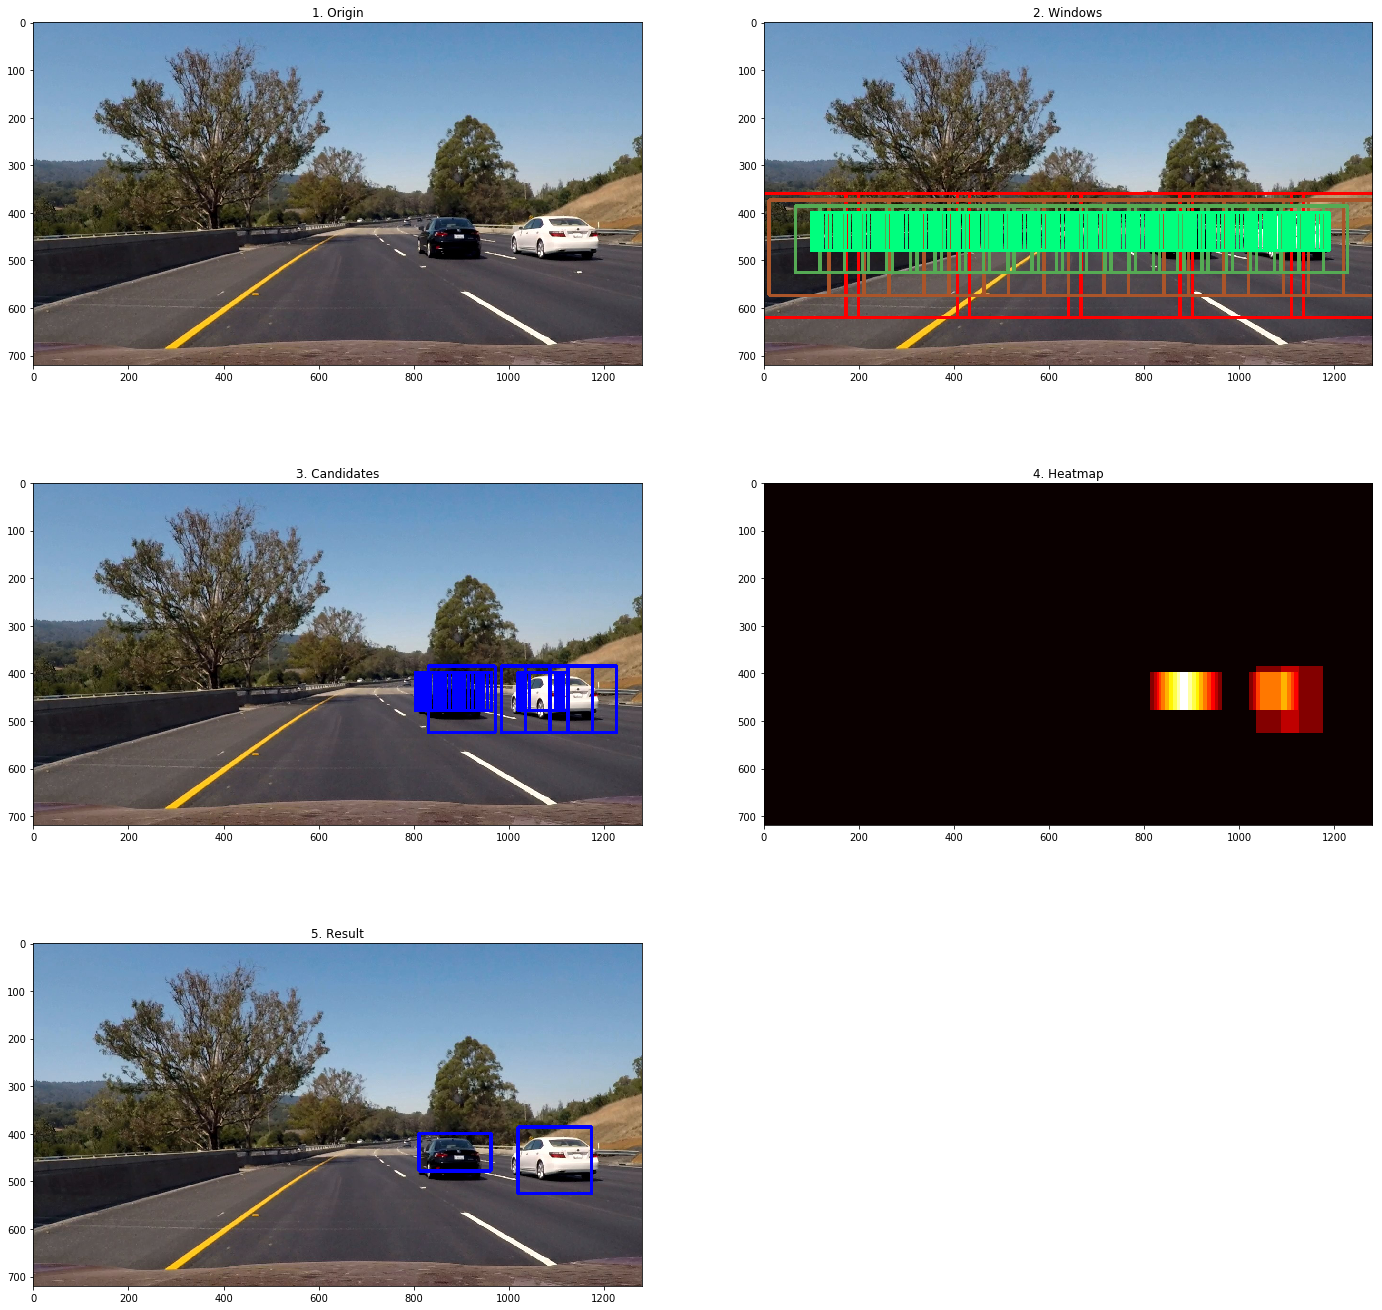

In [13]:
img = mpimg.imread('./test_images/1/0.jpg')
#img = mpimg.imread('./test_images/1/27.jpg')
#img = mpimg.imread('./test_images/608.jpg')
#img = mpimg.imread('./test_images/619.jpg')
#img = mpimg.imread('./test_images/624.jpg')
#img = mpimg.imread('./test_images/625.jpg')
#img = mpimg.imread('./test_images/631.jpg')
#img = mpimg.imread('./test_images/714.jpg')
#img = mpimg.imread('./test_images/745.jpg')
#img = mpimg.imread('./test_images/915.jpg')

svc = classifier
scaler = X_scaler

wins_img, wins = find_windows(img, dx_start=0, dx_stop=100, x_overlap_start=0.1, x_overlap_stop=0.9, n_levels=4)
car_candidates_img, box_list = find_cars(img, wins, svc, scaler, cs, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                                        spatial_feat=True, hist_feat=True, hog_feat=True)
heatmap, final_img, car_boxes = process_car_candidates(img, box_list, 1)

visualize([img, wins_img, car_candidates_img, heatmap, final_img], 3, 2, (24,24), 
          titles=['1. Origin', '2. Windows', '3. Candidates', '4. Heatmap', '5. Result'], img_cmap=None)

## Video Implementation

| **CRITERIA** | **MEETS SPECIFICATIONS** |
|------|------|
| Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.) | The sliding-window search plus classifier has been used to search for and identify vehicles in the videos provided. Video output has been generated with detected vehicle positions drawn (bounding boxes, circles, cubes, etc.) on each frame of video. |

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Detected windows number: 164


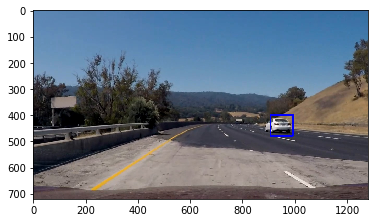

In [15]:
detector1 = CarDetectorSvm(classifier, X_scaler, cs, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
tracker1 = VehicleTracker(detector1, average_model=True, heatmap_threshold=1)


img = mpimg.imread('./test_images/612.jpg')
out_img = tracker1.process_image(img)
plt.imshow(out_img)

In [16]:
# output1 = 'test_video_out.mp4'
# clip1 = VideoFileClip("test_video.mp4")

# detector1 = CarDetectorSvm(classifier, X_scaler, cs, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# tracker1 = VehicleTracker(detector1, average_model=True, heatmap_threshold=1)

# out_clip1 = clip1.fl_image(tracker1.process_image)

# %time out_clip1.write_videofile(output1, audio=False)

In [17]:
output2 = 'project_video_out_notavg.mp4'
clip2 = VideoFileClip("project_video.mp4")

detector2 = CarDetectorSvm(classifier, X_scaler, cs, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
tracker2 = VehicleTracker(detector2, average_model=False, heatmap_threshold=1)

out_clip2 = clip2.fl_image(tracker2.process_image)

%time out_clip2.write_videofile(output2, audio=False)

Detected windows number: 164
[MoviePy] >>>> Building video project_video_out_notavg.mp4
[MoviePy] Writing video project_video_out_notavg.mp4


100%|█████████▉| 1260/1261 [06:45<00:00,  2.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_notavg.mp4 

CPU times: user 7min 25s, sys: 2.45 s, total: 7min 28s
Wall time: 6min 47s


In [18]:
output3 = 'project_video_out_avg.mp4'
clip3 = VideoFileClip("project_video.mp4")

detector3 = CarDetectorSvm(classifier, X_scaler, cs, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
tracker3 = VehicleTracker(detector3, average_model=True, heatmap_threshold=1)

out_clip3 = clip3.fl_image(tracker3.process_image)

%time out_clip3.write_videofile(output3, audio=False)

Detected windows number: 164
[MoviePy] >>>> Building video project_video_out_avg.mp4
[MoviePy] Writing video project_video_out_avg.mp4


100%|█████████▉| 1260/1261 [07:50<00:00,  3.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_avg.mp4 

CPU times: user 8min 35s, sys: 2.92 s, total: 8min 38s
Wall time: 7min 51s


| **CRITERIA** | **MEETS SPECIFICATIONS** |
|------|------|
| Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes. | A method, such as requiring that a detection be found at or near the same position in several subsequent frames, (could be a heat map showing the location of repeat detections) is implemented as a means of rejecting false positives, and this demonstrably reduces the number of false positives. Same or similar method used to draw bounding boxes (or circles, cubes, etc.) around high-confidence detections where multiple overlapping detections occur. |

## Discussion

| **CRITERIA** | **MEETS SPECIFICATIONS** |
|------|------|
| Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust? | Discussion includes some consideration of problems/issues faced, what could be improved about their algorithm/pipeline, and what hypothetical cases would cause their pipeline to fail. |

## Use CNN for prediction

In [19]:
from keras.models import load_model
#model = load_model('./cnn_models/model1.h5')
#model = load_model('./cnn_models/model-2-my-noaug.h5')
#model = load_model('./cnn_models/model3-cnn-noaug.h5')
model = load_model('./cnn_models/model-4-cnn-gray-aug.h5')

gray = True
hist_eq = False

from cnn import predict, predict_classes

Detected windows number: 164
164/164 [==============================] - 0s     
Detected windows number: 164
160/164 [============================>.] - ETA: 0s

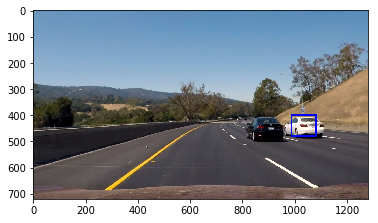

In [20]:
#img = mpimg.imread('./test_images/1/0.jpg')
#img = mpimg.imread('./test_images/1/27.jpg')
#img = mpimg.imread('./test_images/608.jpg')
#img = mpimg.imread('./test_images/619.jpg')
#img = mpimg.imread('./test_images/624.jpg')
#img = mpimg.imread('./test_images/625.jpg')
#img = mpimg.imread('./test_images/631.jpg')
#img = mpimg.imread('./test_images/714.jpg')
#img = mpimg.imread('./test_images/745.jpg')
img = mpimg.imread('./test_images/915.jpg')


car_detector_nn = CarDetectorNN(model, gray, hist_eq)
    
wins_img, wins = find_windows(img)
car_candidates_img, box_list = car_detector_nn.find_car_candidates(img, wins)
heatmap, final_img, car_boxes = process_car_candidates(img, box_list, 1)
#visualize([img, wins_img, car_candidates_img, heatmap, final_img], 3, 2, (12,12), titles=None, img_cmap=None)

tracker_nn = VehicleTracker(car_detector_nn, heatmap_threshold=1)
out_img = tracker_nn.process_image(img)
plt.imshow(out_img)

In [22]:
output4 = 'project_video_out_cnn_avg.mp4'
clip4 = VideoFileClip("project_video.mp4")

detector4 = CarDetectorNN(model, gray, hist_eq)
tracker4 = VehicleTracker(detector4, average_model=True, heatmap_threshold=1)

out_clip4 = clip3.fl_image(tracker4.process_image)

%time out_clip4.write_videofile(output4, audio=False)

Detected windows number: 164
160/164 [============================>.] - ETA: 0s